# Dataset (from Kaggle)

In [ ]:
! pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d awsaf49/brats2020-training-data

100% 6.75G/6.76G [01:16<00:00, 76.8MB/s]
100% 6.76G/6.76G [01:16<00:00, 95.4MB/s]


In [ ]:
import os

extract_dir = 'data/'
if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)


In [ ]:
import zipfile
import shutil

zip_file_path = '/content/brats2020-training-data.zip'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the extracted files (images)
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

Extracted files: ['BraTS2020_training_data', 'BraTS20 Training Metadata.csv']


# MSR Augmentation Implementation

In [ ]:
import torchvision.transforms as transforms

Define augmentation parameters and transforms as required

In [ ]:
msr_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
])

In [ ]:
# augmented_image = msr_augmentation(img)

# SPN Augmentation Implementation

In [ ]:
import torch
import random

In [ ]:
class SPNAugmentation(object):
    def __init__(self, noise_level=0.1):
        self.noise_level = noise_level

    # img - image tensor with shape (C, H, W).
    def __call__(self, img):
        patch_size = 4
        batch_size, C, H, W = img.shape
        num_patches_h = H
        num_patches_w = W

        for b in range(batch_size):
            for h in range(num_patches_h):
                for w in range(num_patches_w):
                    if np.random.rand() < self.noise_level:
                        y1 = h * patch_size
                        y2 = min(y1 + patch_size, H)
                        x1 = w * patch_size
                        x2 = min(x1 + patch_size, W)
                        patch = img[b, :, y1:y2, x1:x2]
                        shuffled_patch = patch[:, np.random.permutation(patch.shape[1]), :][:, :, np.random.permutation(patch.shape[2])]
                        img[b, :, y1:y2, x1:x2] = shuffled_patch

        return img

In [ ]:
spn = SPNAugmentation(noise_level=0.2)
# augmented_image = spn(img)

# Converting Image to C, H, W tensor

In [ ]:
from PIL import Image
import numpy as np
import torch
import h5py


In [ ]:
def convert_h5_to_tensor(path):
    with h5py.File(path, 'r') as file:
        image_array = np.array(file['image'])
        image_tensor = torch.from_numpy(image_array)
        image_tensor = image_tensor.permute(2, 0, 1)
        image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

# Applying the transforms

torch.Size([1, 3, 240, 240])


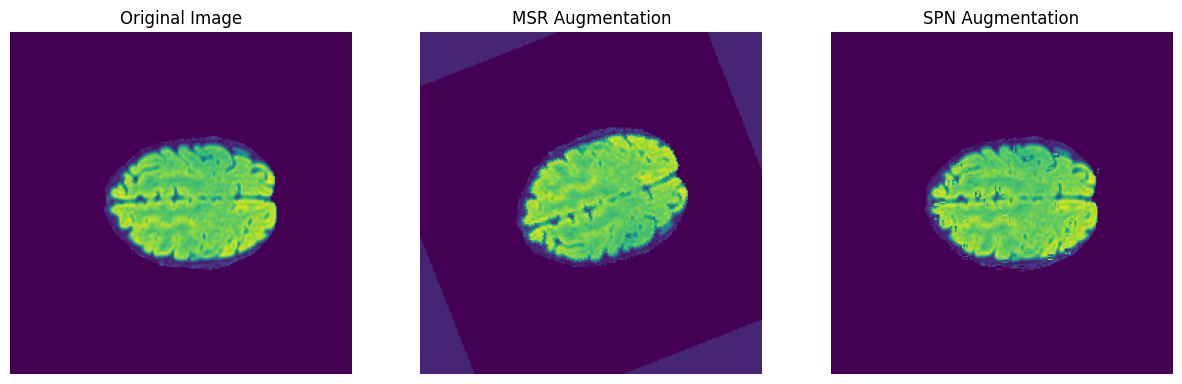

torch.Size([1, 3, 240, 240])


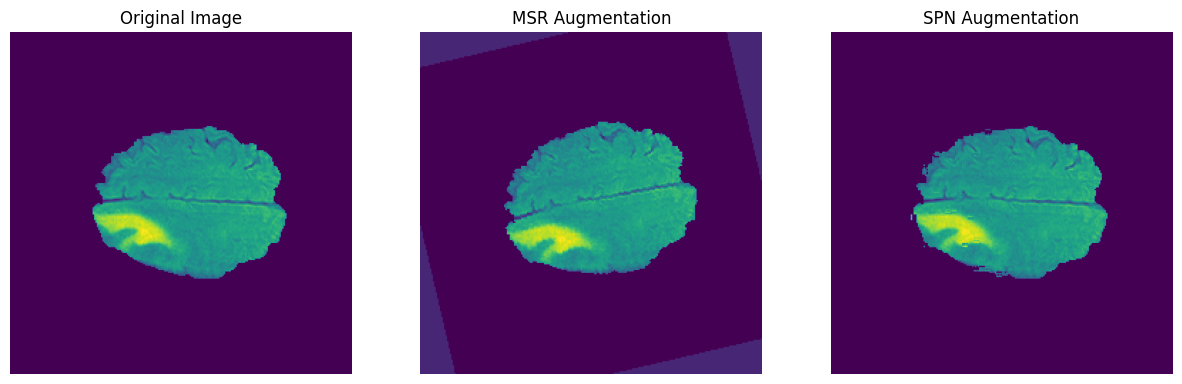

torch.Size([1, 3, 240, 240])


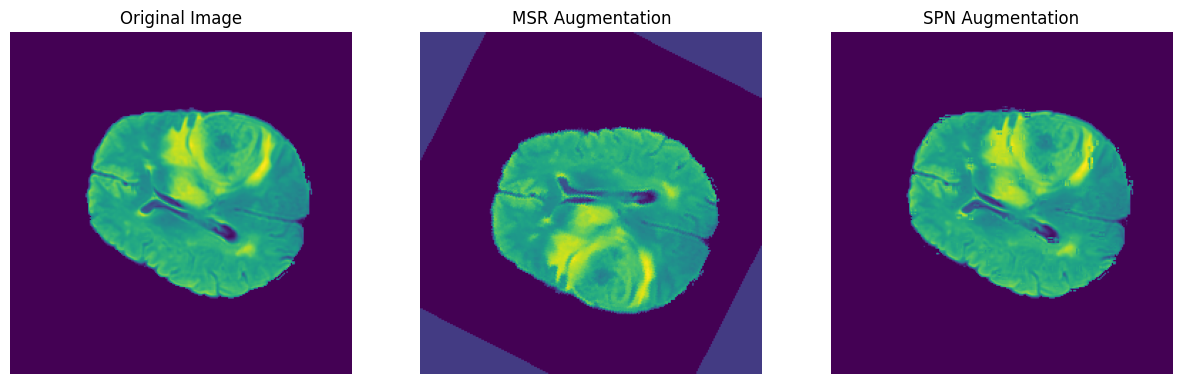

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import h5py

data_dir = '/content/data/BraTS2020_training_data/content/data/'

file_list = ['volume_156_slice_117.h5', 'volume_252_slice_115.h5', 'volume_365_slice_85.h5']

for file_name in file_list:
    file_path = data_dir + file_name
    original_image_tensor = convert_h5_to_tensor(file_path)

    # Convert 4-channel image to 3 channels
    selected_channels = [0, 1, 2]
    original_image_tensor = original_image_tensor[:, selected_channels, :, :]

    # Apply MSR augmentation
    transformed_image_msr = msr_augmentation(original_image_tensor.clone())

    # Apply SPN augmentation
    spn_augmentation = SPNAugmentation(noise_level=0.1)
    print(original_image_tensor.clone().shape)
    transformed_image_spn = spn_augmentation(original_image_tensor.clone())

    # Convert tensors to numpy arrays for display
    original_image = original_image_tensor.squeeze().permute(1, 2, 0).numpy()
    msr_image = transformed_image_msr.squeeze().permute(1, 2, 0).numpy()
    spn_image = transformed_image_spn.squeeze().permute(1, 2, 0).numpy()

    # Display original and augmented images
    displayed_channel = [0]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[:, :, displayed_channel])
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(msr_image[:, :, displayed_channel])
    plt.title('MSR Augmentation')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(spn_image[:, :, displayed_channel])
    plt.title('SPN Augmentation')
    plt.axis('off')

    plt.show()

Future Reference: https://www.kaggle.com/code/atharvabhogale/multi-model-brats

# Applying CNN based segmentation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import numpy as np
import h5py
import os
import torch.nn.functional as F


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
input_channels = 3  # how many channels for the images
num_classes = 2  # Assuming there are 2 classes: background and tumor

model = CNNModel(input_channels, num_classes)

# Applying Meta's Segment Anything Model (SAM)

In [37]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth # default model weights

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-1rh9d_39
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-1rh9d_39
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2024-02-29 08:54:12--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.111, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  50.8MB/s    in 49s     

2024-02-29 08:55:01 (49.9 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [40]:
from segment_anything import sam_model_registry
sam = sam_model_registry["vit_h"]("/content/sam_vit_h_4b8939.pth")

In [53]:
tensor = convert_h5_to_tensor("/content/data/BraTS2020_training_data/content/data/volume_156_slice_117.h5")
tensor_normalized = (tensor - tensor.min()) / (tensor.max() - tensor.min())
# Convert the tensor to a PIL Image


In [64]:
from segment_anything import SamPredictor, SamAutomaticMaskGenerator
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)
# print(tensor_normalized.squeeze(0, 1)[[0,1,2], :, :].shape)
masks = mask_generator.generate(tensor_normalized.squeeze(0, 1)[[0, 1, 2], :, :])

In [66]:
print(len(masks))
print(masks[0].keys())

5
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [67]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

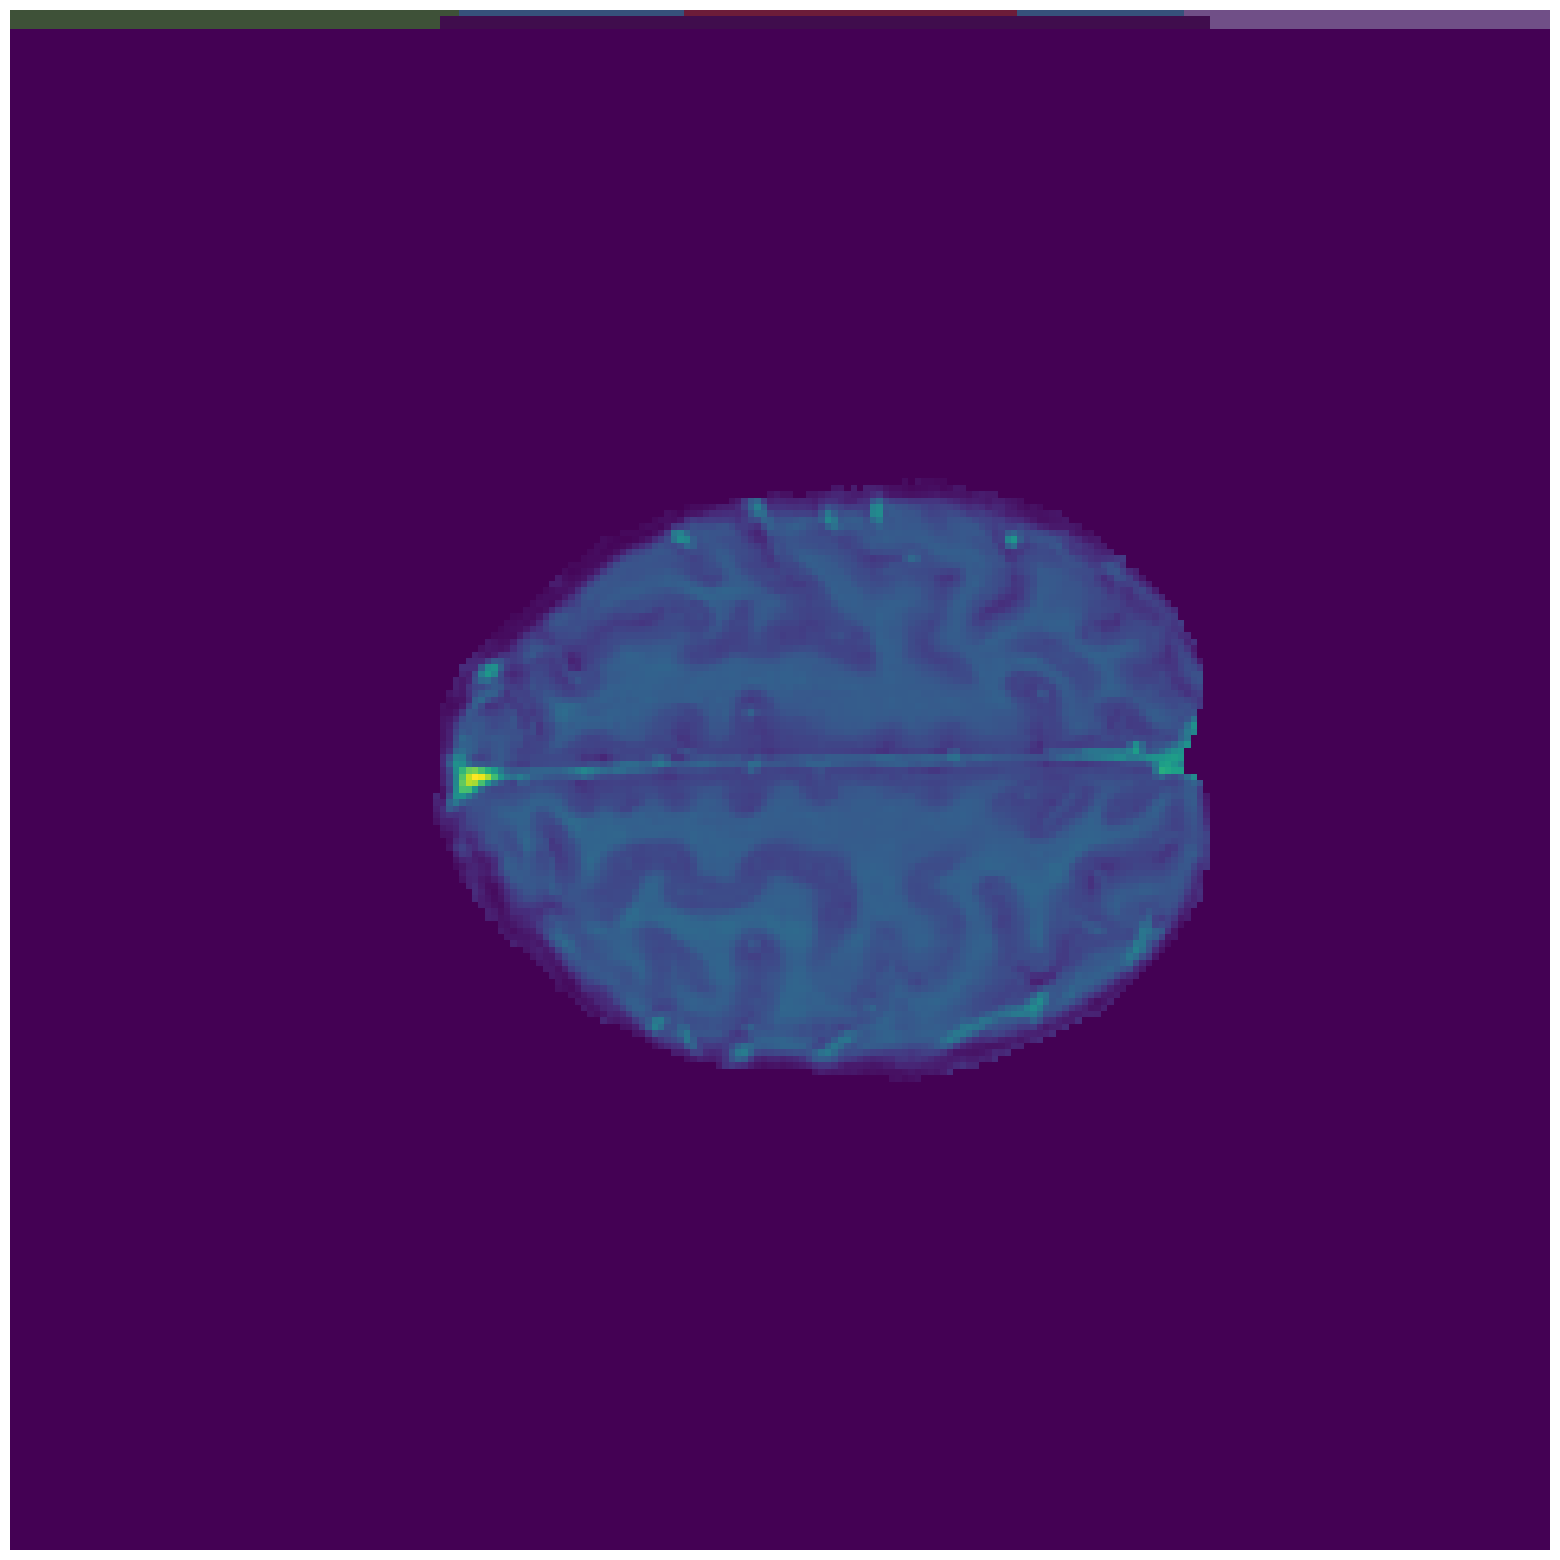

In [83]:
tensor_to_image = transforms.ToPILImage()(tensor_normalized.squeeze(0)[[2], :, :])

plt.figure(figsize=(20,20))
plt.imshow(tensor_to_image)
show_anns(masks)
plt.axis('off')
plt.show()

Usecases: